In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predicción de abandono en telecomunicaciones
El código de la solución se divide en las siguientes secciones:
* Comprensión de datos
* Preprocesamiento
* AED
* Manejar valores faltantes
* Ingeniería de características
* Modelo 1 - Predicción de abandono de clientes
     * Selección de características y reducción de dimensionalidad mediante PCA
     * Manejo de Desequilibrio de Clases usando ADASYN
     * Construcción de modelo de referencia
     * Validación cruzada
     * Ajuste de hiperparámetros
     * Evaluación del modelo
     * Selección de modelo
* Modelo 2: identificación de fuertes predictores de abandono (características importantes)
     * Selección de características usando ExtraTreesClassifier
     * Manejo de Desequilibrio de Clases usando ADASYN
     * Construcción del modelo
     * Ajuste de hiperparámetros con Cross Validation
     * Evaluación del modelo
    
* Recomendación de estrategia para gestionar la rotación de clientes

## PREPROCESAMIENTO:


---

* Comencemos cargando las bibliotecas requeridas.
* También se inicializa la constante global RANDOM_STATE para usar en las siguientes secciones.
* Cargar el archivo del conjunto de datos (telecom_churn_data.csv) desde la carpeta de datos.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.decomposition import PCA

%matplotlib inline
RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')



In [3]:
data = pd.read_csv('/content/drive/MyDrive/XLDiaz/Telecom-Churn-Prediction-master/data/telecom_churn_data.csv')
data.head().T

,0,1,2,3,4
mobile_number,7000842753,7001865778,7001625959,7001204172,7000142493
circle_id,109,109,109,109,109
loc_og_t2o_mou,0.0,0.0,0.0,0.0,0.0
std_og_t2o_mou,0.0,0.0,0.0,0.0,0.0
loc_ic_t2o_mou,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
aon,968,1006,1103,2491,1526
aug_vbc_3g,30.4,0.0,0.0,0.0,0.0
jul_vbc_3g,0.0,0.0,0.0,0.0,0.0
jun_vbc_3g,101.2,0.0,4.17,0.0,0.0


Podemos comenzar a ver algunos patrones útiles en el conjunto de datos.

* mobile_number es la columna de id único para cada cliente.
* las columnas están segregadas por meses de junio (6), julio (7), agosto (8), septiembre (9) para el año 2014.

In [4]:
data.shape

(99999, 226)

In [5]:
# Ahora veremos los tipos de las columnas en el conjunto de datos.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


#### FUNCIONES AUXILIARES PARA EL PREPROCESAMIENTO DE DATOS


In [6]:
'''
Input(s)    : 1 DataFrame
Output(s)   : 6 lists  
Descripción :
- Este método lee las columnas en el marco de datos dado y las divide en varias categorías, como meses, columnas relacionadas con la fecha
   y otras columnas comunes
- Luego devuelve las listas de columnas como salida para cada una de estas categorías.
'''
def get_cols_split(df):

    col_len = len(df.columns)

    jun_cols = []
    jul_cols = []
    aug_cols = []
    sep_cols = []
    common_cols = []
    date_cols = []
    
    for i in range(0, col_len):
        if any(pd.Series(df.columns[i]).str.contains('_6|jun')):
            jun_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_7|jul')):
            jul_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_8|aug')):
            aug_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_9|sep')):
            sep_cols.append(df.columns[i])
        else:
            common_cols.append(df.columns[i])
        
        if any(pd.Series(df.columns[i]).str.contains('date')):
            date_cols.append(df.columns[i])
            
    return jun_cols,jul_cols,aug_cols,sep_cols,common_cols,date_cols

In [7]:
'''
Input(s)    : 1 list
Output(s)   : 4 lists  
Descripción :
- Este método obtiene la lista de columnas como entrada y las divide en varias subcategorías, como call_usage, recharge_columns,
   columnas relacionadas entrantes y salientes
- Luego devuelve las listas de columnas como salida para cada una de estas subcategorías.
'''
def get_cols_sub_split(col_list):
    call_usage_cols = []
    recharge_cols = []
    ic_usage_cols = []
    og_usage_cols = []

    call_usage_search_for = ['og','ic','mou']

    for i in range(0, len(col_list)):
        if any(pd.Series(col_list[i]).str.contains('|'.join(['rech','rch']))):
            recharge_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('|'.join(call_usage_search_for))):
            call_usage_cols.append(col_list[i])

        if any(pd.Series(col_list[i]).str.contains('ic')):
            ic_usage_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('og')):
            og_usage_cols.append(col_list[i])
            
    return call_usage_cols,recharge_cols,ic_usage_cols,og_usage_cols            

Es objetivo tener solo los registros de clientes de alto valor.


---



Para filtrar los registros de clientes de alto valor:

* Se deriva la columna de la cantidad promedio de recarga para los meses de junio y julio (la fase buena)
* Se toma solo los registros que superen el percentil 70 del monto promedio de recarga.
* Descarta la columna recién derivada que no es necesaria.
* Imprime el recuento de filas y columnas del nuevo marco de datos filtrado.

In [8]:
# Obtenga el monto promedio de recarga para los meses 6 y 7
data['avg_rech_amt_6_7'] = ( data['total_rech_amt_6'] + data['total_rech_amt_7'] ) / 2

# Obtener los datos superiores al percentil 70 de la cantidad promedio de recarga
data = data.loc[(data['avg_rech_amt_6_7'] > np.percentile(data['avg_rech_amt_6_7'], 70))]

# Quitar la columna promedio
data.drop(['avg_rech_amt_6_7'], axis=1, inplace=True)

print(data.shape)

(29979, 226)


### CLASIFICAR LOS CLIENTES EN CANCELADOS O NO

Para etiquetar a los clientes cancelados:
* Tome las columnas como 'total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9'
* Encuentre la suma de los valores de las columnas anteriores para cada registro
* Etiquete el registro del cliente como Churned (1) si el valor de la suma es 0 sino Non-Churned (0) y obtenga la columna Churn

In [9]:
tag_churn_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
data['churn'] = np.where(data[tag_churn_cols].sum(axis=1) == 0, 1, 0 )

In [10]:
# Ahora verifique el recuento de clientes abandonados en el conjunto de datos obtenido.
data['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

In [11]:
print('Churn Rate : {0}%'.format(round(((sum(data['churn'])/len(data['churn']))*100),2)))

Churn Rate : 8.64%


La tasa de abandono es inferior al 10 % de los datos generales disponibles. Esto indica que necesitaríamos manejar el desequilibrio de clases en este problema de clasificación.

In [12]:
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = get_cols_split(data)

data.drop(sep_cols, axis=1, inplace=True)

Verificar y eliminar las columnas no deseadas:

---


Ahora podemos verificar las columnas con menos información y eliminarlas si no son necesarias.

In [13]:
# Get the unique count
for col in data.columns:
    print(col, len(data[col].unique()))

mobile_number 29979
circle_id 1
loc_og_t2o_mou 2
std_og_t2o_mou 2
loc_ic_t2o_mou 2
last_date_of_month_6 1
last_date_of_month_7 2
last_date_of_month_8 2
arpu_6 29230
arpu_7 29228
arpu_8 28376
onnet_mou_6 18806
onnet_mou_7 18934
onnet_mou_8 17598
offnet_mou_6 22441
offnet_mou_7 22639
offnet_mou_8 21500
roam_ic_mou_6 4338
roam_ic_mou_7 3649
roam_ic_mou_8 3654
roam_og_mou_6 5174
roam_og_mou_7 4431
roam_og_mou_8 4382
loc_og_t2t_mou_6 11150
loc_og_t2t_mou_7 11152
loc_og_t2t_mou_8 10770
loc_og_t2m_mou_6 16739
loc_og_t2m_mou_7 16865
loc_og_t2m_mou_8 16155
loc_og_t2f_mou_6 3252
loc_og_t2f_mou_7 3267
loc_og_t2f_mou_8 3124
loc_og_t2c_mou_6 1659
loc_og_t2c_mou_7 1750
loc_og_t2c_mou_8 1731
loc_og_mou_6 19677
loc_og_mou_7 19867
loc_og_mou_8 18872
std_og_t2t_mou_6 12773
std_og_t2t_mou_7 12982
std_og_t2t_mou_8 11781
std_og_t2m_mou_6 14512
std_og_t2m_mou_7 14583
std_og_t2m_mou_8 13320
std_og_t2f_mou_6 1774
std_og_t2f_mou_7 1715
std_og_t2f_mou_8 1627
std_og_t2c_mou_6 2
std_og_t2c_mou_7 2
std_og_t2c_mou_

Podemos observar del resultado anterior que:

* Columna Unique_ID - mobile_number
* Columnas de menor información
    * circle_id
    * last_date_of_month_6
    * last_date_of_month_7
    * last_date_of_month_8
    * loc_og_t2o_mou
    * std_og_t2o_mou
    * loc_ic_t2o_mou
    * std_og_t2c_mou_6
    * std_og_t2c_mou_7
    * std_og_t2c_mou_8
    * std_ic_t2o_mou_6
    * std_ic_t2o_mou_7
    * std_ic_t2o_mou_8
    
Echemos un vistazo a algunos registros de muestra de las columnas anteriores.

In [14]:
data[['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']].head(5)

,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
7,7000701601,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7001524846,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,7002191713,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,7000875565,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,7000187447,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Podemos eliminar las columnas enumeradas anteriormente del conjunto de datos.
data.drop(['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1, inplace=True)

Now let's check for the recharge columns value.

In [16]:
# Valor de las columnas de recarga
data[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6']].head()

,total_rech_data_6,av_rech_amt_data_6,max_rech_data_6
7,NaN,NaN,NaN
8,NaN,NaN,NaN
13,NaN,NaN,NaN
16,NaN,NaN,NaN
17,NaN,NaN,NaN


Encontramos que el monto de recarga promedio para las columnas de datos en realidad representa el monto total en lugar del valor promedio. Así que cambiaremos el nombre de las columnas al nombre propio.

In [17]:
data = data.rename(columns={'av_rech_amt_data_6':'total_rech_amt_data_6',
                            'av_rech_amt_data_7':'total_rech_amt_data_7',
                            'av_rech_amt_data_8':'total_rech_amt_data_8'})

### MANEJO DE VALORES FALTANTES

In [18]:
# A continuación, verificaremos el recuento de valores faltantes en el conjunto de datos y 
# enumeraremos las columnas con los valores faltantes.
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
114,count_rech_2g_6,18592
108,total_rech_data_6,18592
120,total_rech_amt_data_6,18592
129,arpu_3g_6,18592
111,max_rech_data_6,18592
...,...,...
46,spl_og_mou_7,303
43,isd_og_mou_7,303
40,std_og_mou_7,303
100,date_of_last_rech_7,114


Ahora utilizaremos la función auxiliar **get_cols_split** para obtener las categorías de columnas.


---



In [19]:
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = get_cols_split(data)

Del mismo modo, la lista de columnas del mes va a la función auxiliar **get_cols_sub_split** para obtener subcategorías de las columnas.


---



In [20]:
# Get the columns sub split for each months
jun_call_usage_cols, jun_recharge_cols, jun_ic_usage_cols, jun_og_usage_cols = get_cols_sub_split(jun_cols)
jul_call_usage_cols, jul_recharge_cols, jul_ic_usage_cols, jul_og_usage_cols = get_cols_sub_split(jul_cols)
aug_call_usage_cols, aug_recharge_cols, aug_ic_usage_cols, aug_og_usage_cols = get_cols_sub_split(aug_cols)

There are few missing values which we will start filling in one by one. 

fb_user and night_pack_user columns are of nominal type 0 and 1. Since missing values could be of another type, imputing them as 2.

In [21]:
# Completar los valores faltantes de las columnas de usuario de fb y night pack como 2,
# ya que este podría ser otro tipo que se marcó como NA
cols_6 = ['fb_user_6','night_pck_user_6']
cols_7 = ['fb_user_7','night_pck_user_7']
cols_8 = ['fb_user_8','night_pck_user_8']

data[cols_6] = data[cols_6].fillna(2)
data[cols_7] = data[cols_7].fillna(2)
data[cols_8] = data[cols_8].fillna(2)

Los valores que faltan para el siguiente conjunto de columnas parecen ser datos no disponibles. Entonces se imponen a 0.

In [22]:
# Los valores que faltan para el siguiente conjunto de columnas parecen ser datos no disponibles. Entonces se imponen a 0.
cols_6 = ['count_rech_3g_6','max_rech_data_6','total_rech_amt_data_6','arpu_3g_6','total_rech_data_6','count_rech_2g_6','arpu_2g_6']
cols_7 = ['count_rech_3g_7','max_rech_data_7','total_rech_amt_data_7','arpu_3g_7','total_rech_data_7','count_rech_2g_7','arpu_2g_7']
cols_8 = ['count_rech_3g_8','max_rech_data_8','total_rech_amt_data_8','arpu_3g_8','total_rech_data_8','count_rech_2g_8','arpu_2g_8']

data[cols_6] = data[cols_6].fillna(0)
data[cols_7] = data[cols_7].fillna(0)
data[cols_8] = data[cols_8].fillna(0)

data[jun_call_usage_cols] = data[jun_call_usage_cols].fillna(0)
data[jul_call_usage_cols] = data[jul_call_usage_cols].fillna(0)
data[aug_call_usage_cols] = data[aug_call_usage_cols].fillna(0)

In [23]:
# Se dejan las columnas de fecha como nulas intencionalmente para la ingeniería de características
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
105,date_of_last_rech_data_6,18592
106,date_of_last_rech_data_7,18327
107,date_of_last_rech_data_8,18238
101,date_of_last_rech_8,594
100,date_of_last_rech_7,114
99,date_of_last_rech_6,62


# VISUALIZACIONES:


---



CURN (ABANDONOS):


---



Como observamos anteriormente, la tasa de abandono es baja en el conjunto de datos general. Así que tendríamos que manejar el desequilibrio de clases.

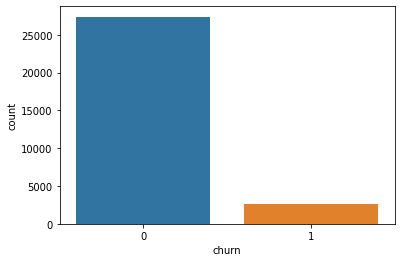

In [24]:
sns.countplot(x='churn', data=data)

Age on Network (AON):


---

* Podríamos ver más número de observaciones entre 1 y 3 años.
* También la tasa de abandono es más alta durante este rango que en los demás.

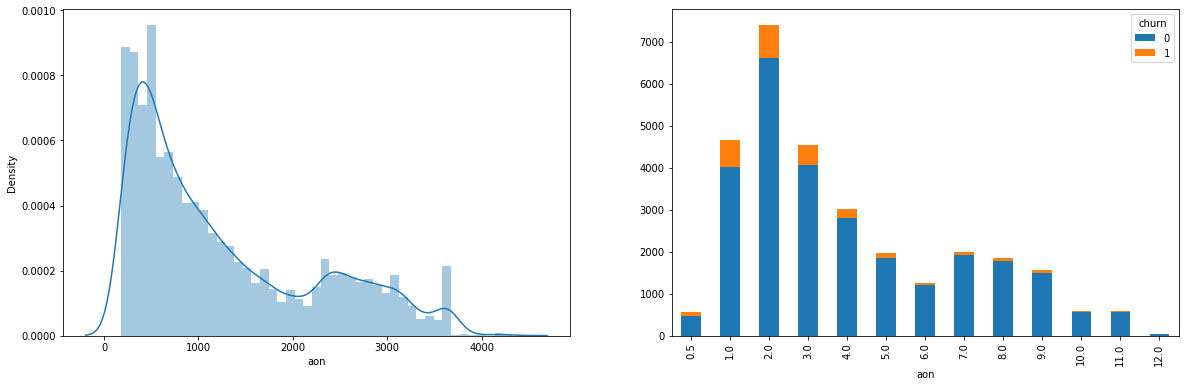

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

sns.distplot(data['aon'], ax=ax1)

bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), data['churn']).plot(kind='bar', stacked=True, ax = ax2)

USO DE LLAMADAS ENTRANTES:


---

Casi todas las columnas de uso de llamadas entrantes parecen tener valores atípicos en el percentil superior.

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,roam_ic_mou_6,spl_ic_mou_6,ic_others_6,total_ic_mou_6
count,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000
mean,244.064853,51.149589,11.14435,17.428073,0.066736,1.189804,307.624011
std,312.931377,140.564801,67.21659,79.192826,0.194321,13.994391,361.286101
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,56.710000,2.630000,0.00000,0.000000,0.000000,0.000000,90.035000
50%,151.080000,15.060000,0.00000,0.000000,0.000000,0.000000,205.340000
75%,315.620000,47.560000,0.00000,0.000000,0.000000,0.060000,393.835000
max,6496.110000,5459.630000,3965.69000,2613.310000,19.760000,1344.140000,6798.640000


,loc_ic_mou_7,std_ic_mou_7,isd_ic_mou_7,roam_ic_mou_7,spl_ic_mou_7,ic_others_7,total_ic_mou_7
count,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000
mean,247.713761,53.394721,12.34135,13.535270,0.018064,1.478162,314.954126
std,315.580778,149.236851,76.96167,76.343222,0.182005,15.414578,369.768358
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,63.550000,2.785000,0.00000,0.000000,0.000000,0.000000,98.840000
50%,154.860000,16.130000,0.00000,0.000000,0.000000,0.000000,211.240000
75%,316.785000,50.390000,0.00000,0.000000,0.000000,0.000000,396.915000
max,6466.740000,6745.760000,4747.91000,3813.290000,21.330000,1495.940000,7279.080000


,loc_ic_mou_8,std_ic_mou_8,isd_ic_mou_8,roam_ic_mou_8,spl_ic_mou_8,ic_others_8,total_ic_mou_8
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,234.331024,48.180997,11.688108,13.263074,0.027609,1.237346,295.472794
std,307.121461,141.009723,74.924529,74.588105,0.116422,12.894187,360.411762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.990000,1.430000,0.000000,0.000000,0.000000,0.000000,78.930000
50%,142.880000,12.560000,0.000000,0.000000,0.000000,0.000000,193.530000
75%,302.110000,43.435000,0.000000,0.000000,0.000000,0.060000,380.450000
max,5748.810000,5957.140000,4100.380000,4169.810000,6.230000,1209.860000,5990.710000


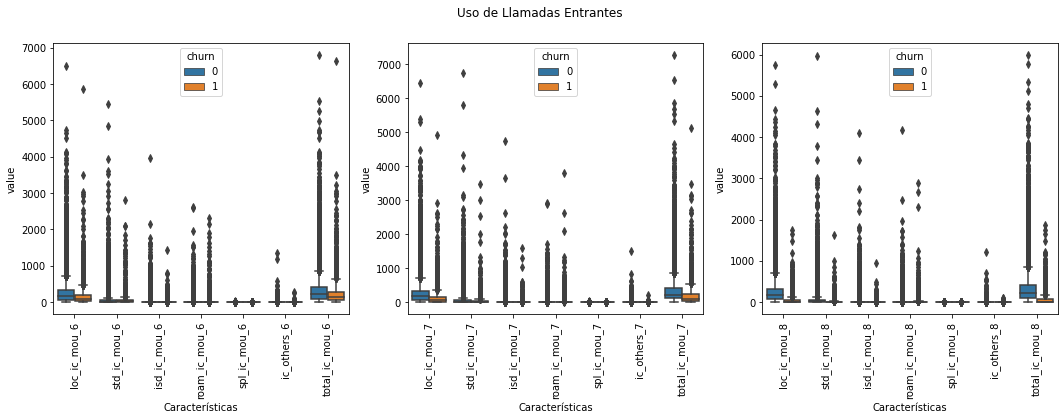

In [26]:
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

for i in range(0,3):
    display(data[cols[i]].describe())

plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Uso de Llamadas Entrantes')

USO DE LLAMADAS SALIENTES:


---

Las columnas de uso de llamadas salientes también parecen tener valores atípicos en el percentil superior.



,loc_og_mou_6,std_og_mou_6,isd_og_mou_6,roam_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,283.058317,395.120001,2.266842,29.348362,5.920726,0.693200,687.068925
std,380.140057,606.718739,45.942529,118.629898,18.630406,2.282437,660.557039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.010000,5.960000,0.000000,0.000000,0.000000,0.000000,266.480000
50%,166.330000,126.360000,0.000000,0.000000,0.210000,0.000000,510.760000
75%,374.600000,573.375000,0.000000,0.000000,5.170000,0.000000,899.960000
max,10643.380000,8432.990000,5900.660000,3775.110000,1023.210000,100.610000,10674.030000


,loc_og_mou_7,std_og_mou_7,isd_og_mou_7,roam_og_mou_7,spl_og_mou_7,og_others_7,total_og_mou_7
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,284.220111,415.617820,2.207826,22.056425,7.429822,0.047651,709.531995
std,375.993720,637.673317,45.642568,97.974803,23.076593,2.743248,685.283264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.710000,5.570000,0.000000,0.000000,0.000000,0.000000,275.275000
50%,170.460000,132.240000,0.000000,0.000000,0.780000,0.000000,526.130000
75%,376.035000,615.440000,0.000000,0.000000,7.130000,0.000000,931.305000
max,7674.780000,10936.730000,5490.280000,2812.040000,1265.790000,370.130000,11365.310000


,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,roam_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
count,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,261.305826,353.81534,2.029675,21.483542,6.889372,0.059194,624.107691
std,366.663849,616.45287,44.817776,106.294911,22.903352,3.322091,686.211375
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.280000,1.78000,0.000000,0.000000,0.000000,0.000000,188.965000
50%,148.280000,73.16000,0.000000,0.000000,0.500000,0.000000,435.810000
75%,348.340000,481.41000,0.000000,0.000000,6.380000,0.000000,833.435000
max,11039.910000,13980.06000,5681.540000,5337.040000,1390.880000,394.930000,14043.060000


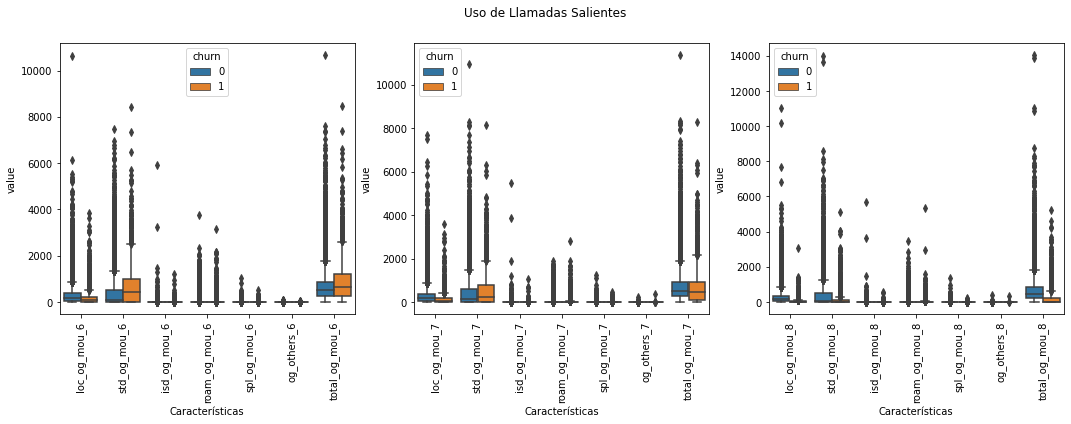

In [27]:
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

for i in range(0,3):
    display(data[cols[i]].describe())

plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Uso de Llamadas Salientes')

MONTO DE RECARGAS:


---



In [28]:
data['total_rech_amt_voice_6'] = np.where((data['total_rech_amt_6'] >= data['total_rech_amt_data_6']),
                                          (data['total_rech_amt_6'] - data['total_rech_amt_data_6']), 0)
data['total_rech_amt_voice_7'] = np.where((data['total_rech_amt_7'] >= data['total_rech_amt_data_7']),
                                          (data['total_rech_amt_7'] - data['total_rech_amt_data_7']), 0)
data['total_rech_amt_voice_8'] = np.where((data['total_rech_amt_8'] >= data['total_rech_amt_data_8']), 
                                          (data['total_rech_amt_8'] - data['total_rech_amt_data_8']), 0)

cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['total_rech_amt_voice_6','total_rech_amt_voice_7','total_rech_amt_voice_8'],
        ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# for i in range(0,4):
#     display(data[cols[i]].describe())

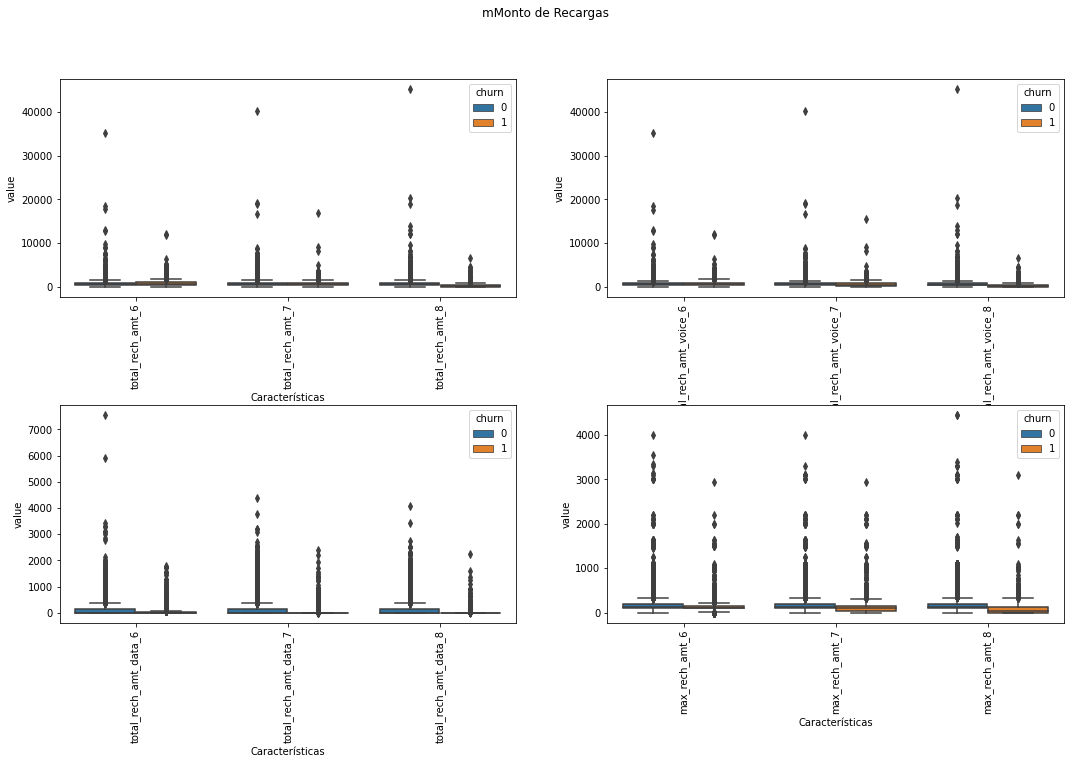

In [29]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('mMonto de Recargas')

CANTIDAD DE RECARGAS:


---



In [30]:
cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
        ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],
        ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'] 
       ]

# for i in range(0,5):
#     display(data[cols[i]].describe())


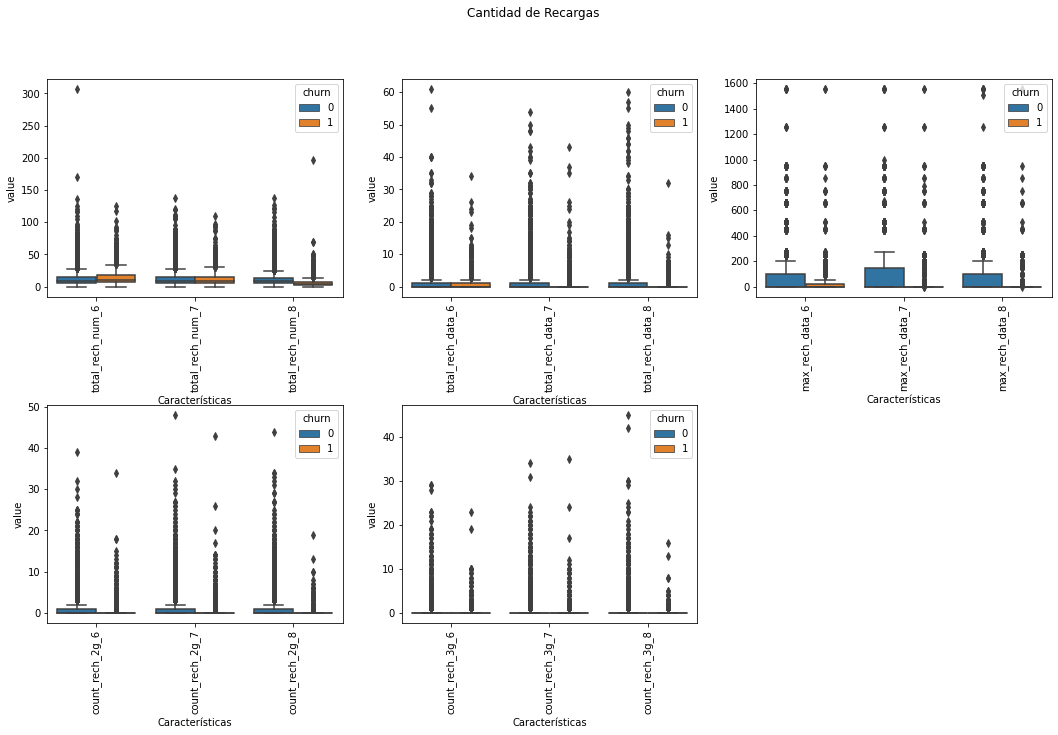

In [31]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5) 
for i in range(0,5):
    plt.subplot(2,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Cantidad de Recargas')

INGRESO PROMEDIO POR USUARIO:


---



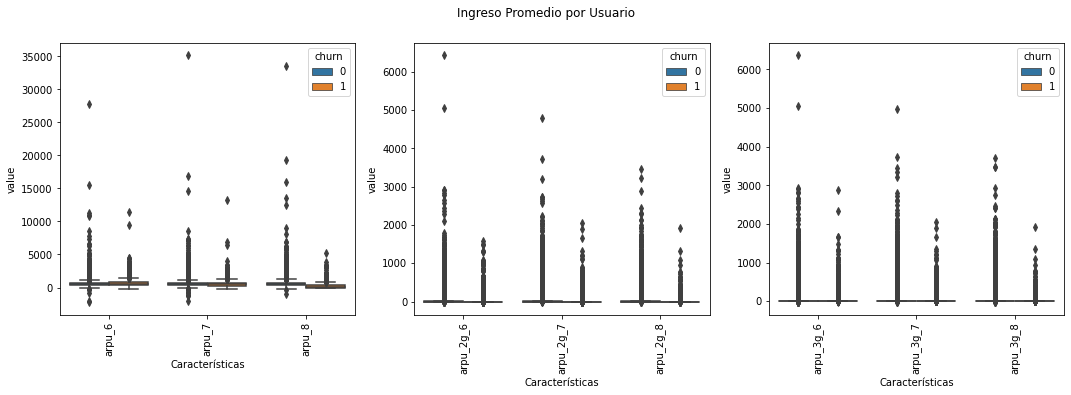

In [32]:
cols = [
        ['arpu_6','arpu_7','arpu_8'],
        ['arpu_2g_6','arpu_2g_7','arpu_2g_8'],
        ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
       ]

# for i in range(0,3):
#     display(data[cols[i]].describe())

plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Ingreso Promedio por Usuario')

2G/3G:


---



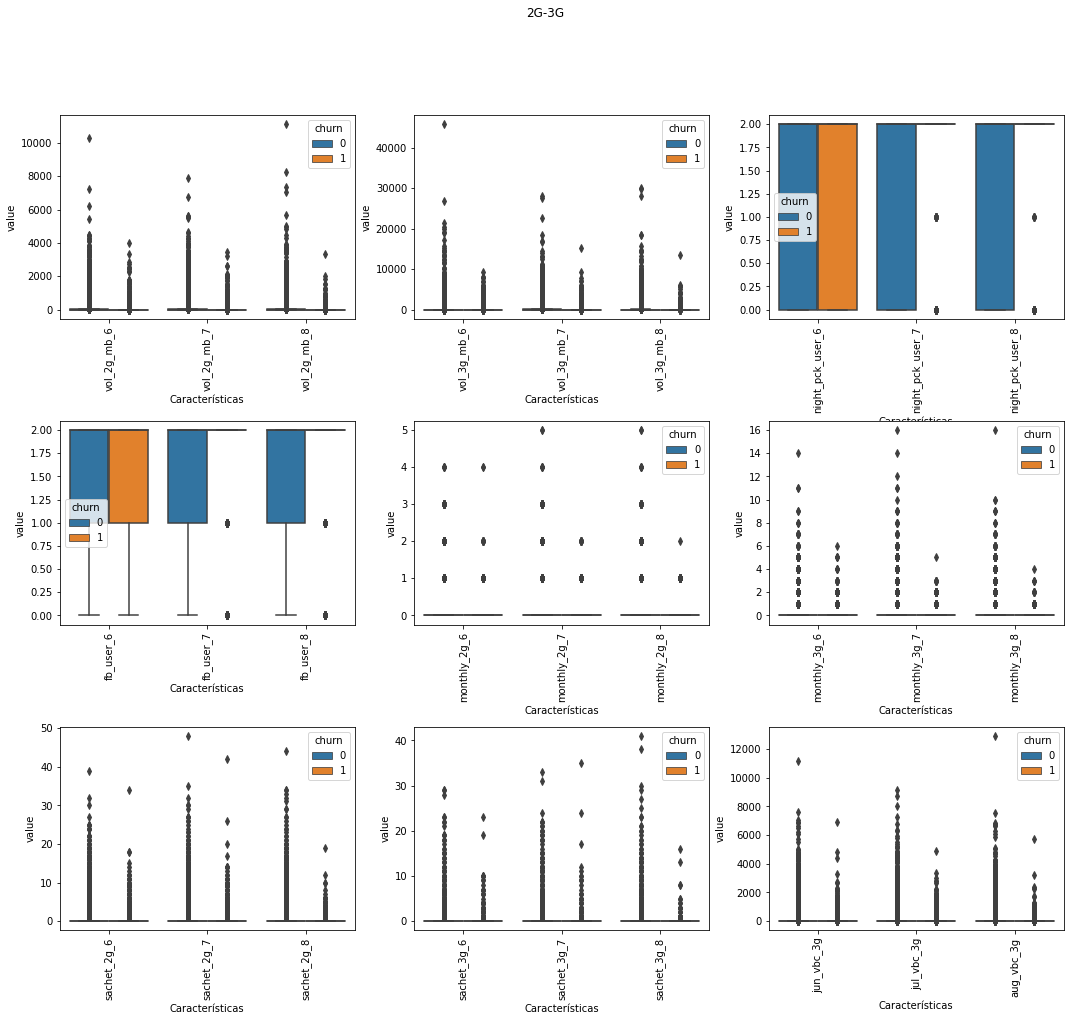

In [33]:
cols = [
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['night_pck_user_6','night_pck_user_7','night_pck_user_8'],
        ['fb_user_6','fb_user_7','fb_user_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
       ]

# for i in range(0,9):
#     display(data[cols[i]].describe())

plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="Características",value_name='value')
    sns.boxplot(x="Características", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('2G-3G')

# TRATAMIENTO DE VALORES ATÍPICOS:


---



Limitar los valores atípicos en el percentil superior.

In [36]:
cols_to_exclude = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                   'fb_user_6','fb_user_7','fb_user_8', 
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn'
                  ]
cols = list(set(data.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = data[col].quantile([0.01,0.99]).values
    #data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

Eliminar los valores atípicos:

---



In [37]:
data = data.loc[~(
                    ((data['roam_og_mou_8'] > 2200) & (data['churn'] == 1)) |
                    ((data['arpu_7'] > 10000) & (data['churn'] == 1)) |
                    ((data['loc_og_mou_8'] > 2000) & (data['churn'] == 1)) |
                    ((data['loc_ic_mou_7'] > 4000) & (data['churn'] == 1)) |
                    ((data['std_og_mou_7'] > 7000) & (data['churn'] == 1)) |
                    ((data['vol_2g_mb_8'] > 2500) & (data['churn'] == 1)) 
                 )
               ]

# INGENIERÍA DE CARACTERÍSTICAS:

Antes de extraer las columnas relacionadas con la fecha, vamos a convertir las columnas al tipo de fecha y hora.

In [38]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y')

Ahora, extraeremos las columnas de la fecha de la última recarga y la fecha de los datos de la última recarga.

In [39]:
cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
# obtener la fecha reciente de recarga en los últimos 3 meses
data['last_rech_date'] = data[cols].max(axis=1)
# obtenga el número de días desde la fecha de recarga reciente hasta la última fecha del mes de agosto
data['days_since_last_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_date'] ).astype('timedelta64[D]'))
# llenar los valores nulos como 0
data['days_since_last_rech'] = data['days_since_last_rech'].fillna(0)

# restarlo de 3 para agregar una ponderación más alta para los valores presentes en todas las columnas.
# len(cols) = 3,  means present in all columns, 0 means not present in any column
data['rech_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))
data.drop(['last_rech_date','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)


cols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
# obtener la fecha reciente de los datos de recarga en los últimos 3 meses
data['last_rech_data_date'] = data[cols].max(axis=1)
# obtener el número de días desde la fecha de datos de recarga reciente hasta la última fecha del mes de agosto
data['days_since_last_data_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_data_date'] ).astype('timedelta64[D]'))
# llenar los valores nulos como 0
data['days_since_last_data_rech'] = data['days_since_last_data_rech'].fillna(0)

# restarlo de 3 para agregar una ponderación más alta para los valores presentes en todas las columnas.
# len(cols) = 3, means present in all columns, 0 means not present in any column
data['rech_data_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))

data.drop(['last_rech_data_date','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

COLUMNAS NUMÉRICAS: USO DE LLAMADAS

---



Del mismo modo, extraeremos los valores medios de las columnas onnet y offnet de los últimos 3 meses (jun, jul, ago)

In [40]:
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
data['mean_onnet_mou'] = round(data[cols].mean(axis=1),2)

cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
data['mean_offnet_mou'] = round(data[cols].mean(axis=1),2)

data['mean_onnet_offnet_mou'] = data['mean_onnet_mou'] + data['mean_offnet_mou']

Extraigamos los valores medios de las columnas entrantes y salientes de roaming durante los últimos 3 meses (jun, jul, ago)

In [41]:
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
data['mean_roam_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
data['mean_roam_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_roam_mou'] = data['mean_roam_ic_mou'] + data['mean_roam_og_mou']

Ahora extraiga los valores medios de las columnas entrantes y salientes locales para varios tipos de operadores durante los últimos 3 meses (junio,julio,agosto)

In [42]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
data['mean_loc_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
data['mean_loc_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2t_mou'] = data['mean_loc_ic_t2t_mou'] + data['mean_loc_og_t2t_mou']

In [43]:
# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
data['mean_loc_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
data['mean_loc_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2m_mou'] = data['mean_loc_ic_t2m_mou'] + data['mean_loc_og_t2m_mou']

In [44]:
# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
data['mean_loc_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
data['mean_loc_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2f_mou'] = data['mean_loc_ic_t2f_mou'] + data['mean_loc_og_t2f_mou']

In [45]:
# loc-t2c columns
cols = ['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']
data['mean_loc_og_t2c_mou'] = round(data[cols].mean(axis=1),2)

In [46]:
# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
data['mean_std_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
data['mean_std_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2t_mou'] = data['mean_std_ic_t2t_mou'] + data['mean_std_og_t2t_mou']

In [47]:
# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
data['mean_std_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
data['mean_std_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2m_mou'] = data['mean_std_ic_t2m_mou'] + data['mean_std_og_t2m_mou']

In [48]:
# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
data['mean_std_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
data['mean_std_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2f_mou'] = data['mean_std_ic_t2f_mou'] + data['mean_std_og_t2f_mou']

In [49]:
# loc columns
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
data['mean_loc_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
data['mean_loc_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_mou'] = data['mean_loc_ic_mou'] + data['mean_loc_og_mou']

In [50]:
# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
data['mean_std_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
data['mean_std_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_mou'] = data['mean_std_ic_mou'] + data['mean_std_og_mou']

In [51]:
# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
data['mean_isd_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
data['mean_isd_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_isd_mou'] = data['mean_isd_ic_mou'] + data['mean_isd_og_mou']

In [52]:
# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
data['mean_spl_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
data['mean_spl_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_spl_mou'] = data['mean_spl_ic_mou'] + data['mean_spl_og_mou']

In [53]:
# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
data['mean_ic_others_mou'] = round(data[cols].mean(axis=1),2)

cols = ['og_others_6','og_others_7','og_others_8']
data['mean_og_others_mou'] = round(data[cols].mean(axis=1),2)

data['mean_others_mou'] = data['mean_ic_others_mou'] + data['mean_og_others_mou']

* Extraigamos los valores medios de las columnas entrantes y salientes de los últimos 3 meses (junio,julio,agosto)
* Extraiga también la ponderación de las columnas entrantes y salientes de los últimos 3 meses (junio,julio,agosto) en orden creciente

In [54]:
cols = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
data['mean_total_ic_mou'] = round(data[cols].mean(axis=1),2)

df = data[cols].astype(bool)
data['total_ic_weightage'] = ( df['total_ic_mou_6'] * 1 ) + ( df['total_ic_mou_7'] * 10 ) + ( df['total_ic_mou_8'] * 100 )

cols = ['total_og_mou_6','total_og_mou_7','total_og_mou_8']
data['mean_total_og_mou'] = round(data[cols].mean(axis=1),2)

df = data[cols].astype(bool)
data['total_og_weightage'] = ( df['total_og_mou_6'] * 1 ) + ( df['total_og_mou_7'] * 10 ) + ( df['total_og_mou_8'] * 100 )

data['mean_total_mou'] = data['mean_total_ic_mou'] + data['mean_total_og_mou']

data['mean_total_mou_6'] = round(data[['total_ic_mou_6','total_og_mou_6']].mean(axis=1),2)
data['mean_total_mou_7'] = round(data[['total_ic_mou_7','total_og_mou_7']].mean(axis=1),2)
data['mean_total_mou_8'] = round(data[['total_ic_mou_8','total_og_mou_8']].mean(axis=1),2)

COLUMNAS NUMÉRICAS: RECARGAS

---

Del mismo modo, extraeremos los valores medio, mínimo y máximo de las columnas relacionadas con la recarga durante los últimos 3 meses (junio,julio,agosto)

In [55]:
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']

data['mean_total_rech_num'] = round(data[cols].mean(axis=1),2)

data['min_total_rech_num'] = data[cols].min(axis=1)

data['max_total_rech_num'] = data[cols].max(axis=1)

In [56]:
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
data['mean_total_rech_amt'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt'] = data[cols].min(axis=1)
data['max_total_rech_amt'] = data[cols].max(axis=1)

In [57]:
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
data['mean_max_rech_amt'] = round(data[cols].mean(axis=1),2)

cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
data['mean_last_day_rch_amt'] = round(data[cols].mean(axis=1),2)

In [58]:
cols = ['total_rech_data_6','total_rech_data_7','total_rech_data_8']
data['mean_total_rech_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_data'] = data[cols].min(axis=1)
data['max_total_rech_data'] = data[cols].max(axis=1)

In [59]:
cols = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8']
data['mean_total_rech_amt_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt_data'] = data[cols].min(axis=1)
data['max_total_rech_amt_data'] = data[cols].max(axis=1)

In [60]:
data['mean_total_rech_voice'] = data['mean_total_rech_num'] - data['mean_total_rech_data']
data['min_total_rech_voice'] = data['min_total_rech_num'] - data['min_total_rech_data']
data['max_total_rech_voice'] = data['max_total_rech_num'] - data['max_total_rech_data']

In [61]:
data['mean_total_rech_amt_voice'] = data['mean_total_rech_amt'] - data['mean_total_rech_amt_data']
data['min_total_rech_amt_voice'] = data['min_total_rech_amt'] - data['min_total_rech_amt_data']
data['max_total_rech_amt_voice'] = data['max_total_rech_amt'] - data['max_total_rech_amt_data']

In [62]:
cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
data['mean_max_rech_data'] = round(data[cols].mean(axis=1),2)

cols = ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8']
data['mean_count_rech_2g'] = round(data[cols].mean(axis=1),2)

cols = ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8']
data['mean_count_rech_3g'] = round(data[cols].mean(axis=1),2)

Extraigamos el peso de las columnas de cantidad y recuento de recargas de los últimos 3 meses (jun, jul, ago) en orden creciente

In [63]:
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
df = data[cols].astype(bool)
data['rech_num_weightage'] = ( df['total_rech_num_6'] * 1 ) + ( df['total_rech_num_7'] * 10 ) + ( df['total_rech_num_8'] * 100 )

In [64]:
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
df = data[cols].astype(bool)
data['rech_amt_weightage'] = ( df['total_rech_amt_6'] * 1 ) + ( df['total_rech_amt_7'] * 10 ) + ( df['total_rech_amt_8'] * 100 )

In [65]:
cols = ['arpu_6','arpu_7','arpu_8']
data['mean_arpu'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_2g_6','arpu_2g_7','arpu_2g_8']
data['mean_arpu_2g_data'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
data['mean_arpu_3g_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8']
data['mean_vol_2g_mb_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']
data['mean_vol_3g_mb_data'] = round(data[cols].mean(axis=1),2)

In [66]:
cols = ['night_pck_user_6','night_pck_user_7','night_pck_user_8']
data['night_pck_weightage'] = ( data['night_pck_user_6'] * 1 ) + ( data['night_pck_user_7'] * 10 ) + ( data['night_pck_user_8'] * 100 )

In [67]:
cols = ['fb_user_6','fb_user_7','fb_user_8']
data['fb_user_weightage'] = ( data['fb_user_6'] * 1 ) + ( data['fb_user_7'] * 10 ) + ( data['fb_user_8'] * 100 )

In [68]:
cols = ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
data['mean_vbc_3g'] = round(data[cols].mean(axis=1),2)

In [69]:
data['monthly_2g_weightage'] = ( data['monthly_2g_6'] * 1 ) + ( data['monthly_2g_7'] * 10 ) + ( data['monthly_2g_8'] * 100 )
data['monthly_3g_weightage'] = ( data['monthly_3g_6'] * 1 ) + ( data['monthly_3g_7'] * 10 ) + ( data['monthly_3g_8'] * 100 )

data['sachet_2g_weightage'] = ( data['sachet_2g_6'] * 1 ) + ( data['sachet_2g_7'] * 10 ) + ( data['sachet_2g_8'] * 100 )
data['sachet_3g_weightage'] = ( data['sachet_3g_6'] * 1 ) + ( data['sachet_3g_7'] * 10 ) + ( data['sachet_3g_8'] * 100 )

Ahora que tenemos todas las funciones necesarias, podemos comenzar a seleccionar las funciones importantes, construir los modelos de referencia y evaluarlos.

# MODELO No: 1


---



SELECCIÓN DE CARARCTERÍSTICAS Y REDUCCIÓN DE DIMENSIONALIDAD MEDIANTE PCA:

---



In [70]:
# Hacer una copia de seguridad del conjunto de datos para su uso posterior
master_df = data.copy()

In [71]:
# Divida las columnas en tipos categóricos y numéricos
churn = data['churn']
data = data.drop('churn', axis=1)


cat_cols = ['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6','fb_user_6',
            'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7','fb_user_7',
            'night_pck_user_8','monthly_2g_8','sachet_2g_8','monthly_3g_8','sachet_3g_8','fb_user_8'] 

num_cols = list(set(data.columns).difference(set(cat_cols)))

CODIFICACIÓN SIMPLE DE LAS CARACTERÍSTICAS CATEGORICAS

---



Se agregan columnas para cada categoría usando una codificación simple

In [72]:
data = pd.concat([data,pd.get_dummies(data[cat_cols], drop_first=True)], axis=1)

data.drop(cat_cols, axis=1, inplace=True)

TRANSFORMACIÓN LOGARÍTMICA DE LAS CARACTERÍSTICAS NUMÉRICAS

---

Como casi todas las características tienen una asimetría positiva, registraremos la transformación de las características numéricas para neutralizar la asimetría positiva en el conjunto de datos.

In [73]:
data[num_cols] = np.log((10000 + data[num_cols]))
data = np.log((10000 + data))

ESTANDARIZAR LAS CARACTERÍSTICAS NUMÉRIICAS


---

Ahora, estandarizaremos (cambiaremos de escala) las características numéricas para que la media sea 0 y la desviación estándar sea 1.



















In [74]:
data[num_cols] = (( data[num_cols] - data[num_cols].mean() ) / data[num_cols].std())

> Antes de comenzar a construir el modelo, verificaremos los valores faltantes una vez para asegurarnos de que los datos estén limpios.

In [75]:
# Check for missing values count
#data = data.replace([np.inf, -np.inf], np.nan)
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt


 MANEJO DE CLASES DESBALANCEADAS USANDO SMOTE O ADASYN:

---



Dado que la tasa de abandono es inferior al 10 % en el conjunto de datos general, aplicaremos la técnica de equilibrio de clases para manejar el desequilibrio.

Entre los mejores algoritmos de muestreo excesivo, comparemos los métodos SMOTE y ADASYN.



Para obtener más detalles, consulte el artículo sobre el manejo de conjuntos de datos desequilibrados en el aprendizaje supervisado: (https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family

Iremos con ADASYN sobre SMOTE ya que SMOTE introducirá más ruido en el conjunto de datos en comparación con ADASYN

In [76]:
X = data
Y = churn

#smote = SMOTE(random_state=RANDOM_STATE, ratio=1.0)
#X, Y = smote.fit_sample(X, Y)

adasyn = ADASYN(random_state=RANDOM_STATE)
X, Y = adasyn.fit_resample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({1: 27628, 0: 27390})


Tenga en cuenta que la clase está bien equilibrada ahora. Ahora podemos dividir el tren y el conjunto de datos de prueba.

SEPARAR EN CONJUNTOS DE ENTRENAMIENTO Y TEST:

---



In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(38512, 225) (38512,)
(16506, 225) (16506,)


## PCA


---

Aplicaremos PCA en el conjunto de datos de entrenamiento para la reducción de la dimensionalidad y la selección de funciones.

In [78]:
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

Se traza el **screeplot** para los componentes de PCA y se elija el número correcto de componentes de PC para construir el modelo

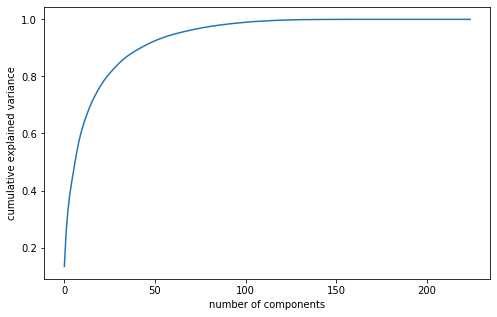

In [79]:
%matplotlib inline
fig = plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Se eligen 50 componentes de PCA para la construcción de modelos

In [80]:
pca = PCA(n_components=50, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_pca = pca.fit_transform(X)

## CONSTRUCCIÓN DE MODELO DE REFERENCIA:

---



In [81]:
# Lista para almacenar las puntuaciones del modelo
model_score_list = []

In [82]:
'''
Input(s)    : 2 series
Output(s)   : 4 float values  
Descripción :
- Este método obtiene 2 series (reales y predichas) como entradas y calcula las puntuaciones de precisión, ROC, precisión y recuperación
- Luego devuelve las puntuaciones calculadas. 
'''
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

### Logistic Regression

In [83]:
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'LogisticRegression', 'acc_score':acc_score,
                         'roc_score':roc_score,'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  80.43
ROC AUC score :  80.43
Precision score :  80.58
Recall score :  80.5


### RidgeClassifier

In [84]:
model = RidgeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'RidgeClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  80.2
ROC AUC score :  80.2
Precision score :  80.64
Recall score :  79.8


### SGDClassifier

In [85]:
model = SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'SGDClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  79.54
ROC AUC score :  79.54
Precision score :  80.02
Recall score :  79.07


### KNN

In [86]:
model = KNeighborsClassifier()

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'KNeighborsClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  88.73
ROC AUC score :  88.66
Precision score :  81.72
Recall score :  99.95


### LinearSVC

In [87]:
model = LinearSVC(class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)


acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'LinearSVC', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  79.17
ROC AUC score :  79.16
Precision score :  78.81
Recall score :  80.13


### SVC

In [88]:
model = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'SVC_Kernel_rbf', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  90.44
ROC AUC score :  90.42
Precision score :  88.49
Recall score :  93.1


### Decision Tree

In [89]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'DecisionTreeClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  86.93
ROC AUC score :  86.91
Precision score :  85.05
Recall score :  89.8


### RandomForest

In [90]:
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'RandomForestClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  95.81
ROC AUC score :  95.8
Precision score :  94.45
Recall score :  97.39


### ExtraTrees

In [91]:
model = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'ExtraTreesClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  96.88
ROC AUC score :  96.87
Precision score :  95.59
Recall score :  98.34


### ADABoost

In [92]:
model = AdaBoostClassifier(random_state=RANDOM_STATE)
model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'AdaBoostClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  79.21
ROC AUC score :  79.21
Precision score :  79.43
Recall score :  79.18


### GradientBoosting

In [93]:
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'GradientBoostingClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  83.21
ROC AUC score :  83.21
Precision score :  83.54
Recall score :  82.98


### XGBoosting

In [94]:
model = XGBClassifier(random_state=RANDOM_STATE)
model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

model_score_list.append({'model_name':'XGBClassifier', 'acc_score':acc_score,
                         'roc_score':roc_score, 'precision_score':prec_score,
                         'recall_score':rec_score})

Accuracy Score :  82.82
ROC AUC score :  82.82
Precision score :  83.22
Recall score :  82.48


## LISTA DE PUNTUACIÓN DE LOS MODELOS:

---



In [95]:
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
3,KNeighborsClassifier,88.73,88.66,81.72,99.95
8,ExtraTreesClassifier,96.88,96.87,95.59,98.34
7,RandomForestClassifier,95.81,95.80,94.45,97.39
5,SVC_Kernel_rbf,90.44,90.42,88.49,93.10
6,DecisionTreeClassifier,86.93,86.91,85.05,89.80
10,GradientBoostingClassifier,83.21,83.21,83.54,82.98
11,XGBClassifier,82.82,82.82,83.22,82.48
0,LogisticRegression,80.43,80.43,80.58,80.50
4,LinearSVC,79.17,79.16,78.81,80.13
1,RidgeClassifier,80.20,80.20,80.64,79.80


### Los 3 modelos principales basados en la puntuación de recuperación son KNeighborsClassifier, ExtraTreesClassifier y RandomForestClassifier

##### KNeighborsClassifier
- La variación entre la puntuación de recuperación y la puntuación de precisión parece ser alta, alrededor del 7 %.
- Pero la puntuación de recuperación es casi del 100 % y la puntuación de roc_auc es un poco baja, del 89 %, en comparación con los otros dos clasificadores principales.

##### ExtraTreesClassifier
- No hay mucha variación en el recuerdo y la puntuación de precisión.
- Además, la puntuación de recuperación y la puntuación de roc_auc están alrededor del 95,5 %, lo que parece ser constante.

##### RandomForestClassifier
- Hay una variación moderada entre la puntuación de recuperación y la puntuación de precisión.
- La puntuación de recuperación es de aproximadamente el 97,3 % y la puntuación de roc_auc es de aproximadamente el 95,6 %.



**Comprobemos el sobreajuste entre los 3 mejores modelos mediante la validación cruzada y seleccionemos un modelo**

## VALIDACIÓN CRUZADA Y SELECCIÓN DE MODELO:

---

Ahora haremos la validación cruzada para los 3 mejores modelos y seleccionaremos un modelo basado en la puntuación media

In [96]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

model = KNeighborsClassifier()
knn_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('KNeighborsClassifier cv_score_mean : ', round(knn_cv_scores.mean() * 100, 2))
print('KNeighborsClassifier cv_score_std : ', round(knn_cv_scores.std() * 100, 2))

model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('RandomForestClassifier cv_score_mean : ', round(rf_cv_scores.mean() * 100, 2))
print('RandomForestClassifier cv_score_std : ', round(rf_cv_scores.std() * 100, 2))

model = ExtraTreesClassifier(random_state=RANDOM_STATE)
etc_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('ExtraTreesClassifier cv_score_mean : ', round(etc_cv_scores.mean() * 100, 2))
print('ExtraTreesClassifier cv_score_std : ', round(etc_cv_scores.std() * 100, 2))


KNeighborsClassifier cv_score_mean :  99.97
KNeighborsClassifier cv_score_std :  0.02
RandomForestClassifier cv_score_mean :  97.75
RandomForestClassifier cv_score_std :  0.15
ExtraTreesClassifier cv_score_mean :  98.58
ExtraTreesClassifier cv_score_std :  0.13


GRÁFICO DE LAS PUNTUACIONES DE VALIDACIÓN CRUZADA PARA LOS 3 MEJORES MODELOS:

---



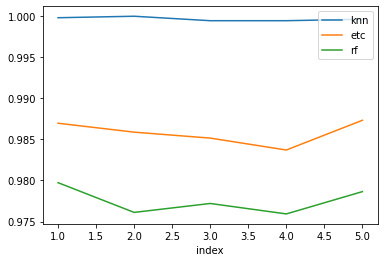

In [97]:
cv_scores_df = pd.DataFrame({'index':np.linspace(1,n_splits,n_splits),'knn':knn_cv_scores,'rf':rf_cv_scores,'etc':etc_cv_scores})
cv_scores_df.plot.line(x='index', y=['knn','etc','rf'])

### Resultados de validación cruzada
##### KNeighborsClassifier
- La puntuación de recuperación es muy consistente entre todos los pliegues

##### RandomForestClassifier y ExtraTreesClassifier
- Estos modelos parecen tener muchas variaciones en la puntuación de recuperación y tiene un problema de sobreajuste.


**Dado que es más importante identificar con precisión a los que abandonan el servicio que a los que no lo hacen, optamos por KNeighborsClassifier, que es consistente y también tiene un alto puntaje de recuerdo**

## AJUSTE DE HIPERPARÁMETROS PARA KNEIGHBORSCLASSIFIER:

---



In [98]:
n_splits = 5
n_neighbors =  [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]
p = [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]

params = {
            'n_neighbors': n_neighbors,
            'p': p
         }

model = KNeighborsClassifier(weights='uniform', n_jobs=-1)

skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

#grid = GridSearchCV(estimator=model, param_grid=params, scoring='recall', n_jobs=-1, cv=skf.split(X,Y), verbose=3 )
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter = 1, scoring='recall',
                          n_jobs=-1, cv=skf.split(X_pca,Y), verbose=3, random_state=RANDOM_STATE )

grid.fit(X_pca, Y)

print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Best estimator:
KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

 Best score:
0.9991312872263243

 Best parameters:
{'p': 2, 'n_neighbors': 3}


**La mejor puntuación de recuerdo que obtenemos con la búsqueda aleatoria es del 99,9994 % y el mejor parámetro es p=2 con n_neighbors=3.**
**Ahora intentemos ajustar el mejor estimador y predecir los resultados**


## MEJOR ESTIMADOR:


---



In [99]:
model = grid.best_estimator_

model.fit(X_train_pca, Y_train)

Y_pred = model.predict(X_test_pca)

Y_pred_proba = model.predict_proba(X_test_pca)

EVALUAR EL MODELO:

---



In [100]:
'''
Input(s)    : 2 Series
Output(s)   : None  
Descripción :
- Este método lee la serie de valores reales y pronosticados
- Calcular los valores de roc_auc
- Calcule el roc_auc_score
- Luego trace la curva roc_auc. 
'''
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [101]:
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89      8203
           1       0.83      1.00      0.91      8303

    accuracy                           0.90     16506
   macro avg       0.92      0.90      0.90     16506
weighted avg       0.92      0.90      0.90     16506


TN = 6559, FP = 1644, FN = 3, TP = 8300


Accuracy Score :  90.02
ROC AUC score :  89.96
Precision score :  83.47
Recall score :  99.96


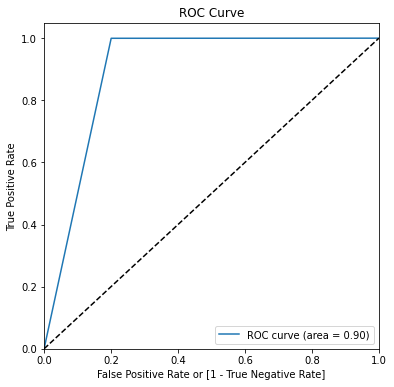

In [102]:
draw_roc(Y_test, Y_pred)

Obtuvimos la **puntuación de recuperación del 99,93 %** con el mejor estimador, que es ligeramente mejor que la puntuación media de la validación cruzada. También el Roc Curve anterior parece estar en buena forma.

Ahora, veamos si podemos optimizar aún más el corte para **minimizar los falsos negativos**

Límite de probabilidad óptimo para minimizar los falsos negativos:

---



In [103]:
Y_pred_final = pd.DataFrame({'actual':Y_test,'pred_nonchurn_prob':Y_pred_proba[:,0],
                             'pred_churn_prob':Y_pred_proba[:,1],'predicted':Y_pred})
Y_pred_final.head(5)

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
35848,1,0.000000,1.000000,1
21070,0,1.000000,0.000000,0
29319,0,0.333333,0.666667,1
53980,1,0.000000,1.000000,1
34371,1,0.000000,1.000000,1


In [104]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    Y_pred_final[i]= Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
Y_pred_final.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
35848,1,0.000000,1.000000,1,1,1,1,1,1,1,1,1,1,1
21070,0,1.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0
29319,0,0.333333,0.666667,1,1,1,1,1,1,1,1,0,0,0
53980,1,0.000000,1.000000,1,1,1,1,1,1,1,1,1,1,1
34371,1,0.000000,1.000000,1,1,1,1,1,1,1,1,1,1,1


In [105]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( Y_pred_final['actual'], Y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.847510  0.693161  1.000000
0.1   0.1  0.847510  0.693161  1.000000
0.2   0.2  0.847510  0.693161  1.000000
0.3   0.3  0.847510  0.693161  1.000000
0.4   0.4  0.900218  0.799586  0.999639
0.5   0.5  0.900218  0.799586  0.999639
0.6   0.6  0.900218  0.799586  0.999639
0.7   0.7  0.946747  0.897842  0.995062
0.8   0.8  0.946747  0.897842  0.995062
0.9   0.9  0.946747  0.897842  0.995062


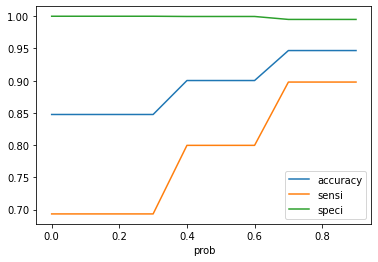

In [106]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [108]:
# Ahora intentemos con el límite de 0,3 y veamos si se pueden reducir los falsos negativos.
Y_pred_final['final_predicted'] = Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > 0.3 else 0)

In [109]:
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred_final['final_predicted']))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_final['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred_final['final_predicted'])


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.69      0.82      8203
           1       0.77      1.00      0.87      8303

    accuracy                           0.85     16506
   macro avg       0.88      0.85      0.84     16506
weighted avg       0.88      0.85      0.84     16506


TN = 5686, FP = 2517, FN = 0, TP = 8303


Accuracy Score :  84.75
ROC AUC score :  84.66
Precision score :  76.74
Recall score :  100.0


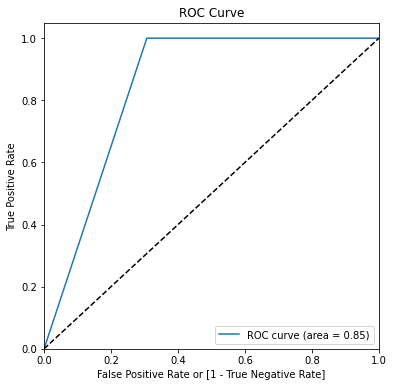

In [110]:
draw_roc(Y_test, Y_pred_final['final_predicted'])

**OBSERVACIÓN:**

---



Cuando la probabilidad de predicción de rotación es de 0,5, tenemos 7 clientes cancelados pronosticados como no cancelados y 1643 clientes no cancelados pronosticados como cancelados.

Para hacer que los 7 clientes cancelados sean cancelados, tenemos que ajustar el límite de probabilidad a 0,3, lo que aumenta los clientes no cancelados pronosticados como cancelados a 2561, lo que representa un aumento considerable en la tasa de falsos positivos.

**Por lo tanto, recomendamos utilizar el límite de probabilidad de 0,5 como predicción final.**

# MODELO No: 2


---


Identificación de fuertes predictores de abandono (características importantes)

SELECCIÓN DE CARACTERÍSTICAS USANDO ExtraTreesClassifier:

---



In [144]:
data = master_df.copy()

churn = data['churn']
data = data.drop('churn', axis=1)

X = data
Y = churn

A continuación, ajustaremos el conjunto de datos en ExtraTreesClassifier y verificaremos la importancia de las características.

In [145]:
model = ExtraTreesClassifier(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X, Y)

feature_imp_df = pd.DataFrame({'Feature':data.columns, 'Score':model.feature_importances_})

feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,199,total_ic_weightage,0.082096
1,201,total_og_weightage,0.058206
2,230,rech_amt_weightage,0.044435
3,154,days_since_last_rech,0.014423
4,210,min_total_rech_amt,0.013392
5,59,loc_ic_t2m_mou_8,0.011810
6,205,mean_total_mou_8,0.011217
7,14,roam_og_mou_8,0.010423
8,65,loc_ic_mou_8,0.010038
9,95,total_rech_amt_8,0.009894


Ahora trazaremos las 50 características más importantes con puntajes:

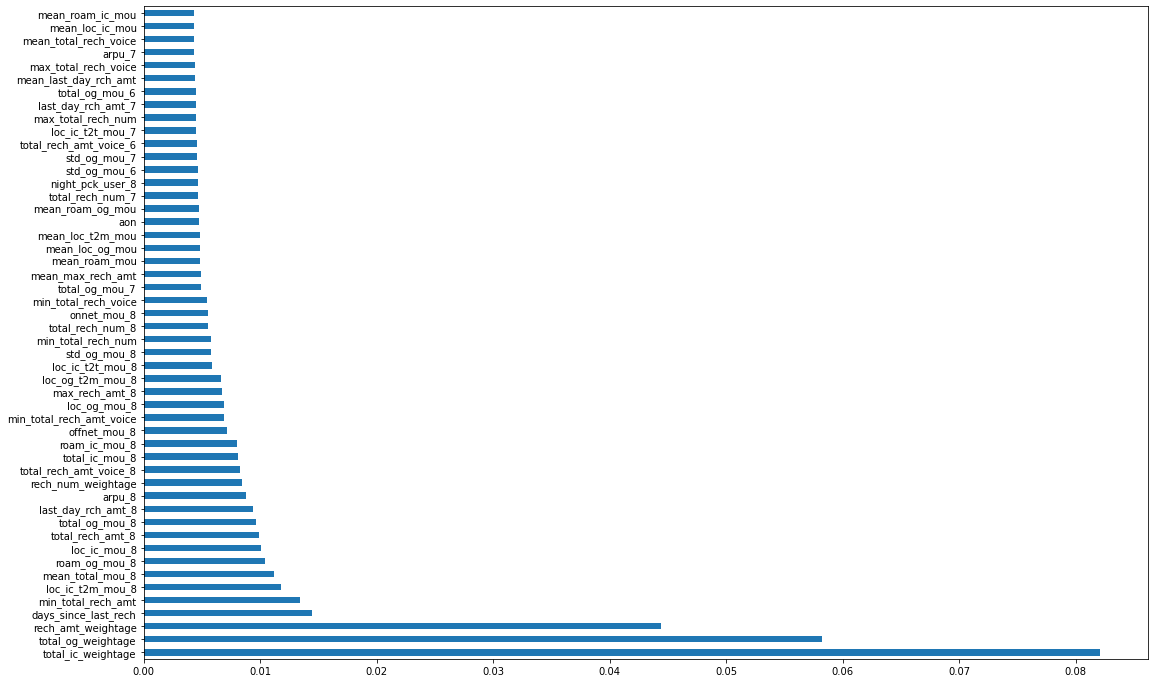

In [146]:
(pd.Series(model.feature_importances_, index=data.columns)
   .nlargest(50)
   .plot(kind='barh', figsize=(18,12))) 

También trace el mapa de calor para las 50 características principales para verificar la correlación entre las características independientes:

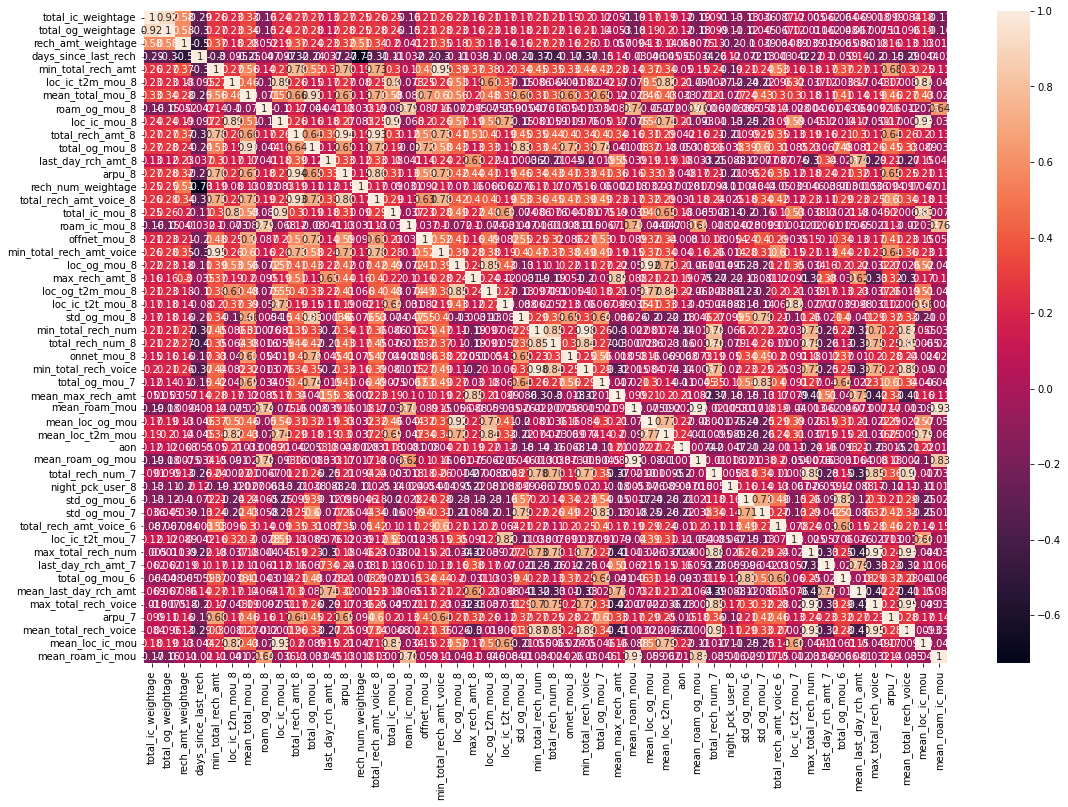

In [147]:
top_50_features = feature_imp_df[:50]['Feature']
plt.figure(figsize=(18,12))
sns.heatmap(data[top_50_features].corr(), annot=True)

* Ahora seleccionaremos solo las características no correlacionadas de las 50 características principales.
* Luego, ajustaremos el modelo lineal generalizado para verificar la importancia de cada característica para el modelo.
* Eliminar las características con valor P alto para manejar la multicolinealidad

In [148]:
cols = ['total_og_weightage','max_rech_amt_8','days_since_last_rech','loc_og_t2m_mou_8','roam_og_mou_8',
        'total_og_mou_8','total_rech_num_8','arpu_8','fb_user_weightage','aon']

X = data[cols]
Y = churn

logm = sm.GLM(Y,(sm.add_constant(X)), family = sm.families.Binomial())
modres = logm.fit()

logm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                29979
Model:                            GLM   Df Residuals:                    29968
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5777.7
Date:                Mon, 05 Sep 2022   Deviance:                       11555.
Time:                        20:31:53   Pearson chi2:                 7.01e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5215      0.130     -3.998      0.000      -0.777      -0.266
total_og_weightage      -0.0206      0.001    -31.588      0.000      -0.022      -0.019
max_rech_amt_8          -0.0015      0.000     -5.155      0.000      -0.002      -0.001
days_since_last_rech     0.0401      0.003     14.423      0.000       0.035       0.045
loc_og_t2m_mou_8        -0.0042      0.000    -12.068      0.000      -0.005      -0.003
roam_og_mou_8            0.0037      0.000     10.406      0.000       0.003       0.004
total_og_mou_8       -1.589e-05   8.16e-05     -0.195      0.846      -0.000       0.000
total_rech_num_8        -0.0159      0.005     -3.145      0.002      -0.026      -0.006
arpu_8                  -0.0007      0.000     -4.263      0.000      -0.001      -0.000
fb_user_weightage        0.0056      0.001     10.466      0.000       0.005       0.007
aon                     -0.0004   3.38e-05    -11.033      0.000      -0.000      -0.000
========================================================================================
"""

In [149]:
# total_og_mou_8 parece tener colinealidad con las otras variables independientes. Entonces, eliminándolo del conjunto de datos
cols = ['total_og_weightage','max_rech_amt_8','days_since_last_rech','loc_og_t2m_mou_8','roam_og_mou_8',
        'total_rech_num_8','arpu_8','fb_user_weightage','aon']
data = data[cols]

## ESTANDARIZAR LAS CARACTERÍSTICAS NUMÉRICAS:

---



Ahora, estandarizaremos (cambiaremos de escala) las características numéricas para que la media sea 0 y la desviación estándar sea 1.

In [150]:
data = (( data - data.mean() ) / data.std())

## MANEJAR EL DESEQULIBRIO DE CLASES USANDO SMOTE O ADASYN:

---



In [151]:
X = data
Y = churn

adasyn = ADASYN(random_state=RANDOM_STATE)
X, Y = adasyn.fit_resample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({1: 28057, 0: 27390})


## SEPARAR EN CONJUNTOS DE ENTRENAMIENTO Y TEST: 

In [152]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(38812, 9) (38812,)
(16635, 9) (16635,)


In [153]:
print('Y_train :', Counter(Y_train))
print('Y_test :', Counter(Y_test))

Y_train : Counter({1: 19648, 0: 19164})
Y_test : Counter({1: 8409, 0: 8226})


### ExtraTrees

In [155]:
model = ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini', max_depth=60, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, 
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1, oob_score=False, random_state=RANDOM_STATE, verbose=0, warm_start=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [156]:
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.94      0.97      8226
           1       0.95      0.99      0.97      8409

    accuracy                           0.97     16635
   macro avg       0.97      0.97      0.97     16635
weighted avg       0.97      0.97      0.97     16635


TN = 7772, FP = 454, FN = 75, TP = 8334


Accuracy Score :  96.82
ROC AUC score :  96.79
Precision score :  94.83
Recall score :  99.11


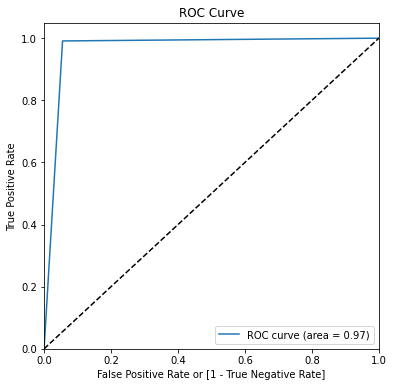

In [157]:
draw_roc(Y_test, Y_pred)

Somos capaces de lograr la **puntuación de recuperación del 98,98 %** con las funciones seleccionadas. Además, la curva ROC anterior parece estar en buena forma.

# RECOMENDACIÓN DE ESTRATEGIA PARA GESTIONAR LA ROTACIÓN DE CLIENTES:

## PLOT DE CONTRIBUCIÓN DE CARACTERÍSTICAS:

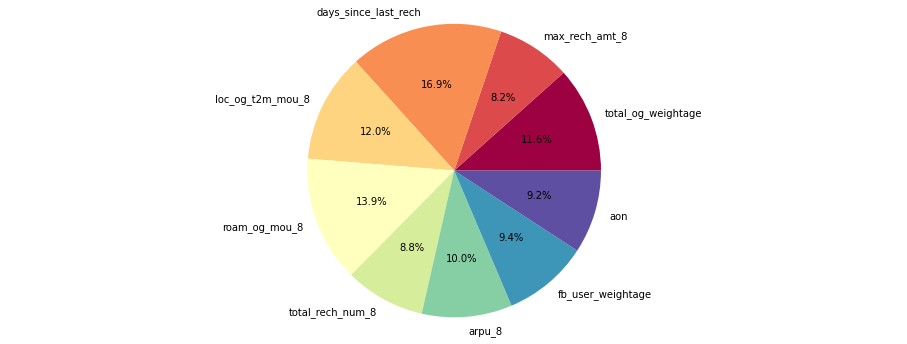

In [158]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

plt.figure(figsize=(16,6))
plt.pie(model.feature_importances_, labels=data.columns, autopct='%1.1f%%', shadow=False, colors=colors)
plt.axis('equal')
plt.show()

## GRÁFICO DE CARACTERÍSTICAS DE ABANDONO:

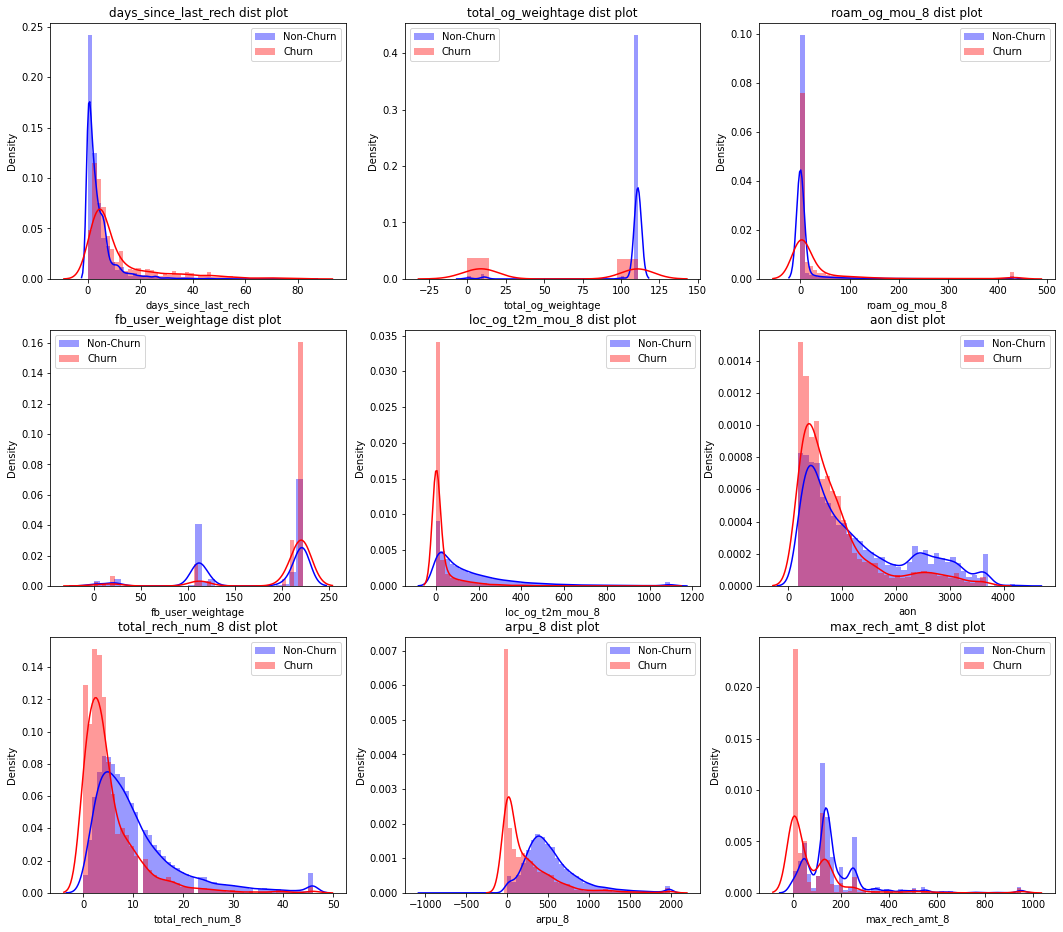

In [159]:
data = master_df.copy()

cols = ['days_since_last_rech','total_og_weightage','roam_og_mou_8','fb_user_weightage','loc_og_t2m_mou_8','aon',
        'total_rech_num_8','arpu_8','max_rech_amt_8']

data = data[cols]
data['churn'] = master_df['churn']

plt.figure(figsize=(18,16))

for i, col in enumerate(cols):

    plt.subplot(3,3,i+1)
    ax = sns.distplot(data.loc[data['churn']==0, [col]], color='b', label='Non-Churn')
    ax = sns.distplot(data.loc[data['churn']==1, [col]], color='r', label='Churn')
    ax.legend()
    plt.xlabel(col)
    plt.title('{0} dist plot'.format(col))

# Conclusión:
**La observación sobre los predictores importantes de la rotación de clientes es la siguiente:**
##### days_since_last_rech
- Representa el número de días desde la última recarga. El valor más bajo tiene una alta tasa de abandono.

##### peso_og_total
- Representa el total de minutos salientes de uso durante los últimos 3 meses con el peso creciente. El valor más bajo obtuvo comparativamente más abandono que el otro.

##### itinerancia_og_mou_8
- Representa el total de minutos salientes de uso en roaming en el último mes. Baje el valor más alto es la tasa de abandono.

##### fb_user_peso
- Representa el uso del paquete de usuario de fb durante los últimos 3 meses con el peso creciente. Cuanto mayor sea el valor, mayor será la tasa de abandono.

##### loc_og_t2m_mou_8
- Representa el total de minutos salientes de uso de llamadas a otros móviles en el último mes. El valor más bajo tiene una alta tasa de abandono.

##### año
- Representa la edad en la red durante los últimos 3 meses. El valor más bajo obtuvo comparativamente más abandono que el otro.

##### total_rech_num_8
- Representa el número total de veces recargadas en el último mes. Baje el valor más alto es la tasa de abandono.

#####arpu_8
- Representa el ingreso promedio por usuario en el último mes. El valor más bajo tiene una alta tasa de abandono.

##### max_rech_amt_8
- Representa el monto máximo recargado en el último mes. El valor más bajo obtuvo comparativamente más abandono que el otro.

## Por lo tanto, recomendamos a la empresa de telecomunicaciones que considere estas variables impulsoras, que son indicadores sólidos para gestionar la rotación de clientes. 